In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from tqdm.notebook import tqdm
from scipy.stats import norm
import plotly.graph_objects as go
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts,StepLR, OneCycleLR

from utils.Models import MLP
from utils.Datasets import BBdataset

torch.manual_seed(233)
np.random.seed(233)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
def gen_bridge(x, y, ts, T, num_samples):
    sigma=1
    bridge = torch.zeros((ts.shape[0], num_samples))
    drift = torch.zeros((ts.shape[0], num_samples))
    bridge[0] = x
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]      # dt = epsilon
        dydt = (y - bridge[i]) / (T - ts[i])
        drift[i, :] = dydt
        diffusion = sigma * torch.sqrt(dt) * torch.randn(num_samples)
        bridge[i+1] = bridge[i] + dydt * dt
        bridge[i+1, :] += diffusion
    return bridge, drift

In [3]:
num_samples = 2000
mu1 = -4
mu2 = 4
sigma = 1
epsilon = 0.001
T = 1


# 定义参数
def gen_data(mu1=-2, mu2=2, sigma=1, num_samples=1000, epsilon=0.001, T=1):
    if not isinstance(num_samples, int):
        num_samples = int(num_samples)
    # 生成初始密度的样本 (标准高斯分布)
    initial_density_samples = np.random.normal(0, 1, 2 * num_samples)

    # 生成终止密度的样本 (两个高斯分布)
    target_density_samples1 = np.random.normal(mu1, sigma, num_samples)
    target_density_samples2 = np.random.normal(mu2, sigma, num_samples)
    target_density_samples = np.concatenate([target_density_samples1, target_density_samples2])

    # 返回生成的样本
    ts = torch.arange(0, T+epsilon, epsilon)
    initial_density_samples = torch.Tensor(initial_density_samples)
    target_density_samples = torch.Tensor(target_density_samples)
    bridge, drift = gen_bridge(initial_density_samples, target_density_samples, ts, T=T, num_samples=2*num_samples)
    return ts, bridge, drift, initial_density_samples, target_density_samples

ts, bridge, drift, source_sample, target_sample = gen_data(mu1=mu1, mu2=mu2, sigma=sigma, num_samples=num_samples/2, epsilon=epsilon, T=T)

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Gaussian to 2$\\times$Gaussian'}>)

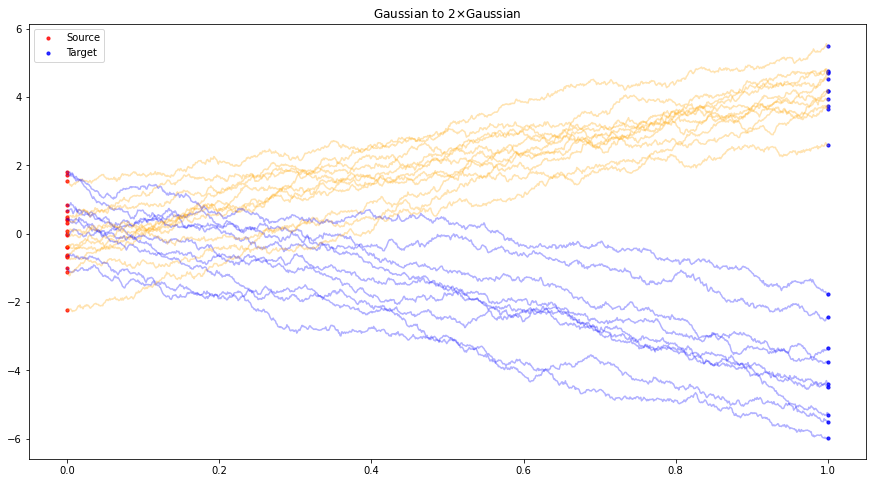

In [4]:
def plot_bridge(ts, bridge, source_sample, target_sample, show_rate=1.0, title=r'Gaussian to 2$\times$Gaussian'):
    if show_rate < 1.0:
        indices = np.arange(len(source_sample))

        # 打乱索引数组
        np.random.shuffle(indices)

        # 重新排列数组
        source_sample = source_sample[indices]
        target_sample = target_sample[indices]
        bridge = bridge[:, indices]
        
        source_sample = source_sample[:int(len(source_sample) * show_rate)]
        target_sample = target_sample[:int(len(target_sample) * show_rate)]
        bridge = bridge[:, :int(bridge.shape[-1] * show_rate)]
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.scatter(np.zeros_like(source_sample), source_sample, c='r', alpha=0.8, label='Source', s=10)
    ax.scatter(np.ones_like(target_sample), target_sample, c='b', alpha=0.8, label='Target', s=10)
    # ax.plot(ts, bridge, c='gray', alpha=0.3)
    
    for i in range(bridge.shape[1]):
        line_color = 'orange' if bridge[-1, i] > 0 else 'blue'
        plt.plot(ts, bridge[:, i], color=line_color, alpha=0.3)
    
    ax.set_title(title)
    ax.legend()
    fig.show()
    return fig, ax

plot_bridge(ts, bridge, source_sample, target_sample, show_rate=0.01)

In [5]:
start = torch.cat(torch.split(source_sample.repeat(len(ts)-1, 1), 1, dim=1), dim=0)
times = ts[:len(ts)-1].repeat(num_samples).reshape(-1, 1)
positions = torch.cat(torch.split(bridge[:-1, :], 1, dim=1), dim=0)

scores = torch.cat(torch.split(drift[:-1, :], 1, dim=1), dim=0)

raw_data = torch.concat([start, times, positions, scores], dim=1)

In [6]:
raw_data.shape

torch.Size([2000000, 4])

In [19]:
def train(model, train_dl, optimizer, scheduler, loss_fn):
    losses = 0
    model.to(device)
    for training_data in train_dl:
        training_data = training_data.float()
        x, y = training_data[:, :, :-1], training_data[:, :, -1:]
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        losses += loss.item() / len(train_dl)
        
    return losses

epochs = 10
batch_size = 1000
lr = 1e-4

# 组合成data
train_ds = BBdataset(raw_data)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = MLP(input_dim=3, output_dim=1, hidden_layers=4, hidden_dim=512)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
loss_list = []
print('='*10+'model'+'='*10)
print("batch_szie:{}, channel:{}, length:{}".format(*next(train_dl.__iter__()).shape)) # batch_szie, channel, length
print(model)

==========model==========
batch_szie:1000, channel:1, length:4
MLP(
  (fcin): Linear(in_features=3, out_features=512, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (fcout): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)


In [20]:
epoch_iterator = tqdm(range(epochs), desc="Training (lr: X)  (loss= X)", dynamic_ncols=True)
model.train()
for e in epoch_iterator:
    now_loss = train(model ,train_dl, optimizer, None, loss_fn)
    loss_list.append(now_loss)
    cur_lr = optimizer.param_groups[-1]['lr']
    epoch_iterator.set_description("Training (lr: %2.5f)  (loss=%2.5f)" % (cur_lr, now_loss))
epoch_iterator.close()

Training (lr: X)  (loss= X):   0%|          | 0/10 [00:00<?, ?it/s]

In [66]:
# torch.save(model.state_dict(), 'gaussian2gaussian.pth')

In [67]:
test_num_samples = 100
test_ts, test_bridge, test_drift, test_source_sample, test_target_sample = gen_data(mu1=mu1, mu2=mu2, sigma=sigma, num_samples=test_num_samples/2, epsilon=epsilon, T=T)
pred_bridge = torch.zeros((test_ts.shape[0], test_num_samples))
pred_bridge[0, :] = test_source_sample
model.eval()
model.cpu()
with torch.no_grad():
    for i in range(len(test_ts) - 1):
        dt = (test_ts[i+1] - test_ts[i])
        test_source_sample_reshaped = test_source_sample.reshape(-1, 1, 1)
        test_ts_reshaped = test_ts[i].reshape(-1, 1, 1).repeat(test_num_samples, 1, 1)
        pred_bridge_reshaped = pred_bridge[i].reshape(-1, 1, 1)
        x = torch.concat([test_source_sample_reshaped, test_ts_reshaped, pred_bridge_reshaped], axis=-1)
        dydt = model(x)
        dydt = dydt[:, 0, 0]
        diffusion = sigma * torch.sqrt(dt) * torch.randn(test_num_samples)
        pred_bridge[i+1, :] = pred_bridge[i, :] + dydt * dt + diffusion

In [68]:
pred_bridge.shape

torch.Size([1001, 100])

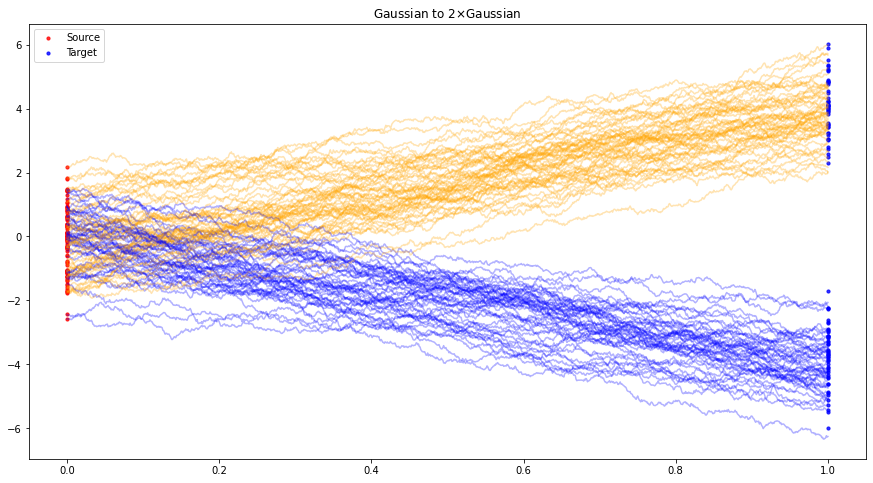

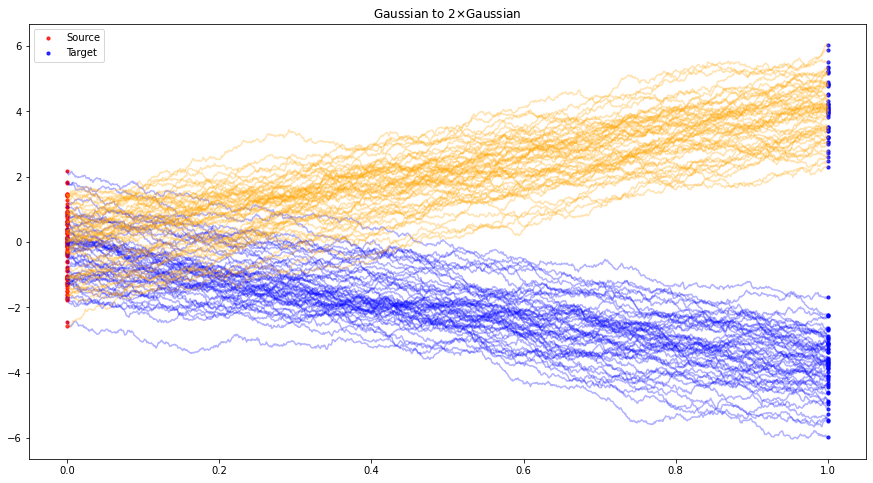

In [78]:
plot_bridge(test_ts, pred_bridge, test_source_sample, test_target_sample, show_rate=1)
plot_bridge(test_ts, test_bridge, test_source_sample, test_target_sample, show_rate=1)
plt.savefig('outs/gaussian2gaussian_bridge.jpg', dpi=300, bbox_inches='tight')